<a href="https://colab.research.google.com/github/amirkasaei/Intelligent-Analysis-of-Biomedical-Images/blob/main/HW/HW4/Prac/MIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer Detection using Multiple Instance Learning (MIL)



In this part we are going implement the idea proposed by the paper "Breast Cancer Histopathology Image Classification
and Localization using Multiple Instance Learning" and reproduce some of their results.

https://arxiv.org/pdf/2003.00823.pdf

You can read the "Attention-based Deep Multiple Instance Learning" paper for more explanation. Here is the link to it:

https://arxiv.org/pdf/1802.04712.pdf

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import glob
import random
import torch.utils.data as data_utils
import torch.optim as optim
from torch.autograd import Variable
import cv2

## Downloading dataset

Link to the dataset's website:

https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/

In [ ]:
!wget http://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz -O /content/BreaKHis_v1.tar.gz

--2023-12-26 17:08:00--  http://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz
Resolving www.inf.ufpr.br (www.inf.ufpr.br)... 200.17.202.113, 2801:82:80ff:8001:216:ccff:feaa:79
Connecting to www.inf.ufpr.br (www.inf.ufpr.br)|200.17.202.113|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz [following]
--2023-12-26 17:08:01--  https://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz
Connecting to www.inf.ufpr.br (www.inf.ufpr.br)|200.17.202.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4273561758 (4.0G) [application/octet-stream]
Saving to: ‘/content/BreaKHis_v1.tar.gz’

/content/BreaKHis_v 100%[===================>]   3.98G  16.5MB/s    in 4m 6s   

2023-12-26 17:12:08 (16.6 MB/s) - ‘/content/BreaKHis_v1.tar.gz’ saved [4273561758/4273561758]



In [ ]:
!tar xzf /content/BreaKHis_v1.tar.gz -C /content

## Data Preparation

- A custom pytorch Dataset for our data.
- Transformations to perform on data
- Patch extraction code
- Dataloaders

In [ ]:
classes = ['benign', 'malignant']
magnifications = ["40X", "100X", "200X", "400X"]
features = ['image_path', 'condition', 'magnification', 'class', 'label']

In [ ]:
path='/content/BreaKHis_v1/histology_slides/breast'

In [ ]:
data = {
    '40X': [],
    '100X': [],
    '200X': [],
    '400X': []
}

for i, _class in enumerate(classes):
  for condition in os.listdir(path+'/'+_class+'/SOB/'):
    for sample in os.listdir(path+'/'+_class+'/SOB/'+condition+'/'):
      for magnification in os.listdir(path+'/'+_class+'/SOB/'+condition+'/'+sample+'/'):
        for patch in os.listdir(path+'/'+_class+'/SOB/'+condition+'/'+sample+'/'+magnification+'/'):
          image_path = path+'/'+_class+'/SOB/'+condition+'/'+sample+'/'+magnification+'/'+patch
          data[magnification].append([image_path, condition, magnification, _class, i])


In [ ]:
dataframe = {}
for magnification in magnifications:
  dataframe[magnification] = pd.DataFrame(data[magnification],columns=features)
  print(dataframe[magnification].shape)

(1995, 5)
(2081, 5)
(2013, 5)
(1820, 5)


In [ ]:
dataframe['100X'].head()

,image_path,condition,magnification,class,label
0,/content/BreaKHis_v1/histology_slides/breast/b...,phyllodes_tumor,100X,benign,0
1,/content/BreaKHis_v1/histology_slides/breast/b...,phyllodes_tumor,100X,benign,0
2,/content/BreaKHis_v1/histology_slides/breast/b...,phyllodes_tumor,100X,benign,0
3,/content/BreaKHis_v1/histology_slides/breast/b...,phyllodes_tumor,100X,benign,0
4,/content/BreaKHis_v1/histology_slides/breast/b...,phyllodes_tumor,100X,benign,0


In [ ]:
# Implement the custom dataset here (15 points)
class CustomBreaKHis(Dataset):
    def __init__(self, df, magn, transform=None):
        # To-Do
        self.magnification = magn
        self.trasnform = transform
        self.samples = np.array(df[['image_path', 'label']])
        self.centercrop = T.Compose([T.CenterCrop((448,700))]) #centercropping to generate 9 400x400 patches

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):

        image_path, label = self.samples[index]

        t = T.Compose([T.CenterCrop((448,700))]) #centercropping to generate 9 400x400 patches

        transformations = T.Compose([T.ToTensor()])

        array = []

        # patch extraction
        image = Image.open(image_path)
        image = np.array(t(image))
        r, c, _ = image.shape
        for i in range(0,28*16,28):
            for j in range(0,28*25,28):
                array.append(transformations(image[i:i+28, j:j+28, :]))


        array = tuple(array)
        array = torch.stack(array, 0)
        # array[torch.randperm(array.size()[0])]


        return (array, label)

In [ ]:
# Implement the transforms here (5 points)
PILimage = T.Compose([
    T.ToPILImage()
])

t = T.Compose([T.CenterCrop((448,700))]) #centercropping to generate 9 400x400 patches

transformers = [
    T.functional.vflip,
    T.functional.hflip,
    T.RandomRotation((90, 90)),
    T.RandomRotation((180, 180)),
    T.RandomRotation((270, 270))
]


randomAug = T.RandomApply([T.RandomChoice(transformers)], p=0.5)

transformations = T.Compose([
    T.ToPILImage(),
    T.RandomApply([T.RandomChoice(transformers)], p=0.5),
    T.ToTensor(),
])

In [ ]:
# img = t(Image.open(dataframe['200X']['image_path'].iloc[0]))
# print(type(img))
# plt.imshow(PILimage(transformations(img)))

In [ ]:
datasets = {
    '40X': {},
    '100X': {},
    '200X': {},
    '400X': {},
}

for magn in magnifications:
  ds = CustomBreaKHis(dataframe[magn], magn, transform=transformations)
  datasets[magn]['train'], datasets[magn]['valid'], datasets[magn]['test'] = torch.utils.data.random_split(ds, [0.8, 0.05, 0.15])

In [ ]:
# Create dataloaders here (5 points)
phases = ['train', 'valid', 'test']

dataloaders = {
    '40X': {},
    '100X': {},
    '200X': {},
    '400X': {},
}

for magn in magnifications:
  for phase in phases:
    shuffle = (phase == 'train')
    dataloaders[magn][phase] =  torch.utils.data.DataLoader(datasets[magn][phase], shuffle = shuffle, batch_size = 1)

In [ ]:
# Implement patch extraction here (10 points)
# If you are going to implement it somewhere else, please comment it here.
# patch extraction is implemented in the _getitem function of dataset

## Model Implementation

In [ ]:
# Implement the model here (25 points)
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.L = 500
        self.D = 128
        self.K = 1

        self.feature_extractor_part1 = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(50 * 4 * 4, self.L),
            nn.ReLU(),
        )

        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.L*self.K, 1),
            nn.Sigmoid()
        )

    def forward(self, x):

        x = x.squeeze(0)

        H = self.feature_extractor_part1(x)
        H = H.view(-1, 50 * 4 * 4)
        H = self.feature_extractor_part2(H)  # NxL

        A = self.attention(H)  # NxK
        A = torch.transpose(A, 1, 0)  # KxN
        A = F.softmax(A, dim=1)  # softmax over N

        M = torch.mm(A, H)  # KxL

        Y_prob = self.classifier(M)
        Y_hat = torch.ge(Y_prob, 0.5).float()

        return Y_prob, Y_hat, A

    # AUXILIARY METHODS
    def calculate_classification_error(self, X, Y):
        Y = Y.float()
        _, Y_hat, _ = self.forward(X)
        error = 1. - Y_hat.eq(Y).cpu().float().mean().item()

        return error, Y_hat

    def calculate_objective(self, X, Y):
        Y = Y.float()
        Y_prob, _, A = self.forward(X)
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=1. - 1e-5)
        neg_log_likelihood = -1. * (Y * torch.log(Y_prob) + (1. - Y) * torch.log(1. - Y_prob))  # negative log bernoulli

        return neg_log_likelihood, A

## Training

### Helper Functions

In [ ]:
def validate_one_epoch(loader):
  model.eval()
  valid_loss = 0.

  valid_error = 0.
  correct_label_pred = 0

  for batch_idx, (data, label) in enumerate(loader):

      bag_label = label[0]
      data, bag_label = data.to(device), bag_label.to(device)
      data, bag_label = Variable(data), Variable(bag_label)
      data = data.squeeze(0)

      optimizer.zero_grad()

      # calculate loss and metrics
      with torch.set_grad_enabled(False):
        loss, _ = model.calculate_objective(data, bag_label)
        error, predicted_label_valid = model.calculate_classification_error(data, bag_label)

      # statistics
      valid_loss += loss.item()
      valid_error += error
      correct_label_pred += (int(bag_label) == int(predicted_label_valid))


  # calculate loss and error for epoch
  valid_loss /= len(loader)
  valid_error /= len(loader)
  valid_acc = (1 - valid_error)

  return valid_loss, valid_error, valid_acc

In [ ]:
# Implement the training method here (20 points)
max_steps = 200
def train_one_epoch(loader):
  model.train()
  train_loss = 0.
  train_error = 0.
  correct_label_pred = 0

  for batch_idx, (data, label) in enumerate(loader):
      if batch_idx > 200:
        break

      bag_label = label[0]
      data, bag_label = data.to(device), bag_label.to(device)
      data, bag_label = Variable(data), Variable(bag_label)
      data = data.squeeze(0)

      optimizer.zero_grad()

      # calculate loss and metrics
      with torch.set_grad_enabled(True):
        loss, A = model.calculate_objective(data, bag_label)
        error, predicted_label_train = model.calculate_classification_error(data, bag_label)

        # backward pass
        loss.backward()
        # step
        optimizer.step()

      # statistics
      train_loss += loss.item()
      train_error += error
      correct_label_pred += (int(bag_label) == int(predicted_label_train))
      # break


  # calculate loss and error for epoch
  # train_loss /= len(loader)
  # train_error /= len(loader)
  train_loss /= max_steps
  train_error /= max_steps
  train_acc = (1 - train_error)

  return train_loss, train_error, train_acc

In [ ]:
def train(model, dataloader, epochs):

  best_valid_loss = float('inf')
  best_valid_acc = 0
  # best_model = None

  accuracy_dic, loss_dic = {}, {}
  loss_dic['train'], loss_dic['valid'] = [], []
  accuracy_dic['train'], accuracy_dic['valid'] = [], []

  for epoch in range(epochs):
    train_loss, train_error, train_acc = train_one_epoch(dataloader['train'])
    valid_loss, valid_error, valid_acc = validate_one_epoch(dataloader['valid'])

    loss_dic['train'].append(train_loss)
    loss_dic['valid'].append(valid_loss)
    accuracy_dic['train'].append(train_acc)
    accuracy_dic['valid'].append(valid_acc)

    if valid_loss < best_valid_loss:
      best_valid_acc = valid_acc
      best_valid_loss = valid_loss
      # best_model = model.state_dict()
      torch.save(model.state_dict(), model_path)

    print(f'Epoch [{epoch+1}/{epochs}] - '
            f'Train Loss: {train_loss:.4f} - '
            f'Train Accuracy: {train_acc:.4f} - '
            f'Valid Loss: {valid_loss:.4f} - '
            f'Valid Accuracy {valid_acc:.4f}%')

  return loss_dic, accuracy_dic

In [ ]:
def show_plots(num_epochs, data, metric):
  e = np.arange(num_epochs)
  plt.plot(e, data['train'], label='train '+metric)
  plt.plot(e, data['valid'], label='validation '+metric)
  plt.xlabel('epoch')
  plt.ylabel(metric)
  plt.legend()

### Model Confuguration

In [ ]:
RANDOM_SEED = 42 # Must be used wherever can be used

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model_path = '/content/model.pt'

In [ ]:
model = Attention()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=10e-5)

### **40X**

In [ ]:
# Train the model on the 40X data here (1 points)
epochs = 60
magn = "40X"
loss_dic, accuracy_dic = train(model, dataloaders[magn], epochs)

Epoch [1/60] - Train Loss: 0.6581 - Train Accuracy: 0.6600 - Valid Loss: 0.6561 - Valid Accuracy 0.6667%
Epoch [2/60] - Train Loss: 0.6458 - Train Accuracy: 0.6500 - Valid Loss: 0.5952 - Valid Accuracy 0.6667%
Epoch [3/60] - Train Loss: 0.6124 - Train Accuracy: 0.6600 - Valid Loss: 0.5868 - Valid Accuracy 0.6667%
Epoch [4/60] - Train Loss: 0.5743 - Train Accuracy: 0.7050 - Valid Loss: 0.5616 - Valid Accuracy 0.8283%
Epoch [5/60] - Train Loss: 0.4999 - Train Accuracy: 0.7650 - Valid Loss: 0.5390 - Valid Accuracy 0.6970%
Epoch [6/60] - Train Loss: 0.5508 - Train Accuracy: 0.7300 - Valid Loss: 0.5135 - Valid Accuracy 0.8384%
Epoch [7/60] - Train Loss: 0.4903 - Train Accuracy: 0.7750 - Valid Loss: 0.4909 - Valid Accuracy 0.8182%
Epoch [8/60] - Train Loss: 0.5049 - Train Accuracy: 0.7650 - Valid Loss: 0.5058 - Valid Accuracy 0.7576%
Epoch [9/60] - Train Loss: 0.4944 - Train Accuracy: 0.7950 - Valid Loss: 0.4885 - Valid Accuracy 0.8283%
Epoch [10/60] - Train Loss: 0.4725 - Train Accuracy: 0.

#### Plots

In [ ]:
# Plot loss and accuracy per epoch for 40X here (2 points)

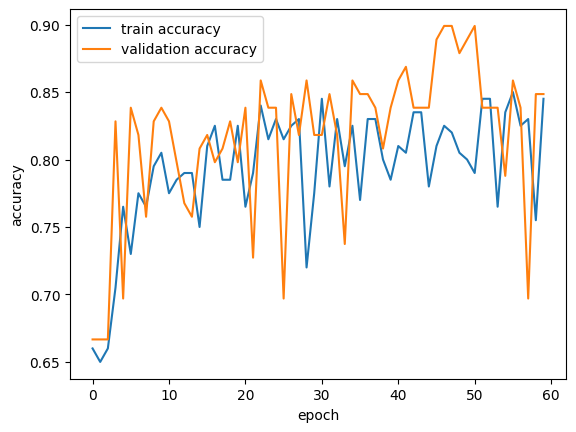

In [ ]:
show_plots(epochs, accuracy_dic, 'accuracy')

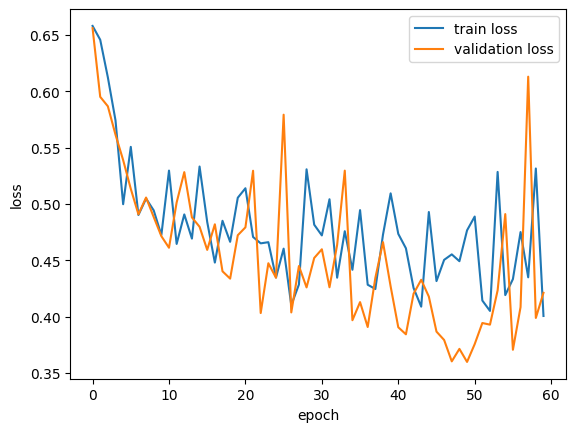

In [ ]:
show_plots(epochs, loss_dic, 'loss')

### **100X**

In [ ]:
model.load_state_dict(torch.load(model_path))
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=10e-5)

In [ ]:
# Train the model on the 100X data here (1 points)
epochs = 60
magn = "100X"
loss_dic, accuracy_dic = train(model, dataloaders[magn], epochs)

Epoch [1/60] - Train Loss: 0.4618 - Train Accuracy: 0.7900 - Valid Loss: 0.3621 - Valid Accuracy 0.8846%
Epoch [2/60] - Train Loss: 0.4048 - Train Accuracy: 0.8500 - Valid Loss: 0.3116 - Valid Accuracy 0.8942%
Epoch [3/60] - Train Loss: 0.4280 - Train Accuracy: 0.8250 - Valid Loss: 0.2949 - Valid Accuracy 0.9231%
Epoch [4/60] - Train Loss: 0.4262 - Train Accuracy: 0.8350 - Valid Loss: 0.2618 - Valid Accuracy 0.9231%
Epoch [5/60] - Train Loss: 0.4184 - Train Accuracy: 0.8300 - Valid Loss: 0.3822 - Valid Accuracy 0.8077%
Epoch [6/60] - Train Loss: 0.4241 - Train Accuracy: 0.8300 - Valid Loss: 0.2888 - Valid Accuracy 0.9327%
Epoch [7/60] - Train Loss: 0.3430 - Train Accuracy: 0.8650 - Valid Loss: 0.2610 - Valid Accuracy 0.9327%
Epoch [8/60] - Train Loss: 0.4417 - Train Accuracy: 0.8100 - Valid Loss: 0.2867 - Valid Accuracy 0.9231%
Epoch [9/60] - Train Loss: 0.4527 - Train Accuracy: 0.7950 - Valid Loss: 0.2898 - Valid Accuracy 0.9327%
Epoch [10/60] - Train Loss: 0.4326 - Train Accuracy: 0.

#### Plots

In [ ]:
# Plot loss and accuracy per epoch for 100X here (2 points)

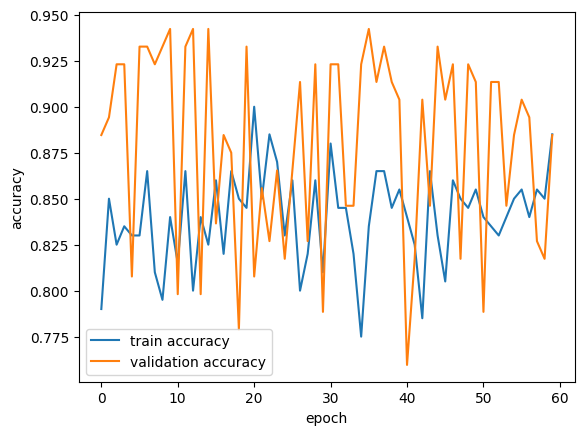

In [ ]:
show_plots(epochs, accuracy_dic, 'accuracy')

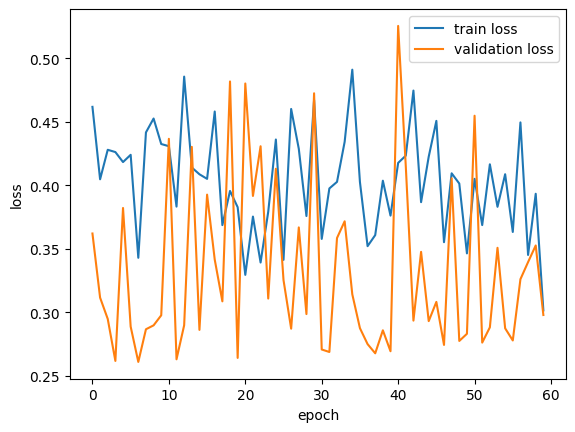

In [ ]:
show_plots(epochs, loss_dic, 'loss')

### **200X**

In [ ]:
model.load_state_dict(torch.load(model_path))
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=10e-5)

In [ ]:
# Train the model on the 200X data here (1 points)
epochs = 60
magn = "200X"
loss_dic, accuracy_dic = train(model, dataloaders[magn], epochs)

Epoch [1/60] - Train Loss: 0.4334 - Train Accuracy: 0.8500 - Valid Loss: 0.4617 - Valid Accuracy 0.7921%
Epoch [2/60] - Train Loss: 0.3292 - Train Accuracy: 0.8800 - Valid Loss: 0.7545 - Valid Accuracy 0.6337%
Epoch [3/60] - Train Loss: 0.4170 - Train Accuracy: 0.8300 - Valid Loss: 0.4749 - Valid Accuracy 0.7822%
Epoch [4/60] - Train Loss: 0.2974 - Train Accuracy: 0.9200 - Valid Loss: 0.3892 - Valid Accuracy 0.8911%
Epoch [5/60] - Train Loss: 0.3370 - Train Accuracy: 0.8650 - Valid Loss: 0.4939 - Valid Accuracy 0.7822%
Epoch [6/60] - Train Loss: 0.3036 - Train Accuracy: 0.9100 - Valid Loss: 0.5993 - Valid Accuracy 0.7525%
Epoch [7/60] - Train Loss: 0.4339 - Train Accuracy: 0.8350 - Valid Loss: 0.5573 - Valid Accuracy 0.7624%
Epoch [8/60] - Train Loss: 0.3316 - Train Accuracy: 0.8950 - Valid Loss: 0.3307 - Valid Accuracy 0.8911%
Epoch [9/60] - Train Loss: 0.3400 - Train Accuracy: 0.8900 - Valid Loss: 0.3251 - Valid Accuracy 0.8911%
Epoch [10/60] - Train Loss: 0.4217 - Train Accuracy: 0.

#### Plots

In [ ]:
# Plot loss and accuracy per epoch for 200X here (2 points)

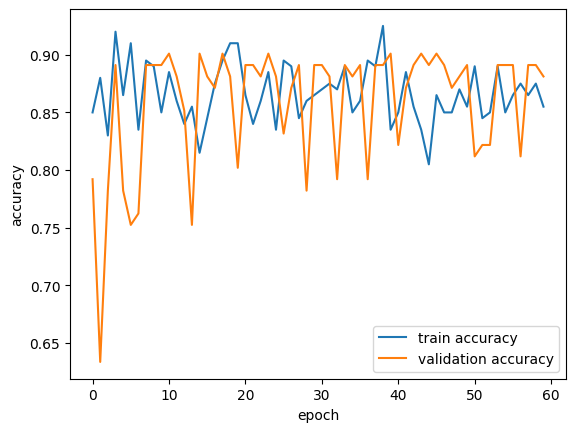

In [ ]:
show_plots(epochs, accuracy_dic, 'accuracy')

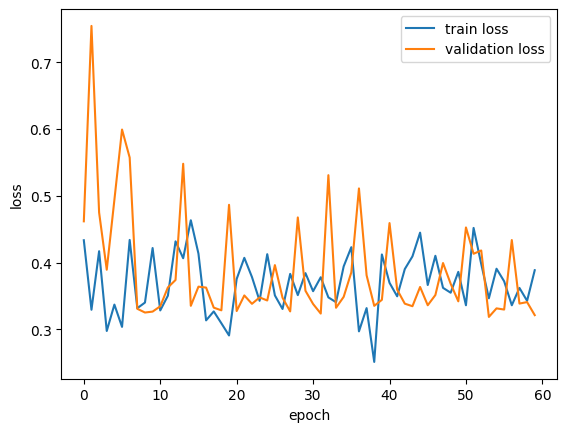

In [ ]:
show_plots(epochs, loss_dic, 'loss')

### **400X**

In [ ]:
model.load_state_dict(torch.load(model_path))
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=10e-5)

In [ ]:
# Train the model on the 400X data here (1 points)
epochs = 60
magn = "400X"
loss_dic, accuracy_dic = train(model, dataloaders[magn], epochs)

Epoch [1/60] - Train Loss: 0.2553 - Train Accuracy: 0.9250 - Valid Loss: 0.4829 - Valid Accuracy 0.8132%
Epoch [2/60] - Train Loss: 0.4111 - Train Accuracy: 0.8700 - Valid Loss: 0.4733 - Valid Accuracy 0.8242%
Epoch [3/60] - Train Loss: 0.3402 - Train Accuracy: 0.8700 - Valid Loss: 0.4418 - Valid Accuracy 0.8352%
Epoch [4/60] - Train Loss: 0.3582 - Train Accuracy: 0.8700 - Valid Loss: 0.4622 - Valid Accuracy 0.8132%
Epoch [5/60] - Train Loss: 0.3170 - Train Accuracy: 0.8950 - Valid Loss: 0.4475 - Valid Accuracy 0.8352%
Epoch [6/60] - Train Loss: 0.3459 - Train Accuracy: 0.8850 - Valid Loss: 0.4610 - Valid Accuracy 0.8132%
Epoch [7/60] - Train Loss: 0.2887 - Train Accuracy: 0.8800 - Valid Loss: 0.4768 - Valid Accuracy 0.8352%
Epoch [8/60] - Train Loss: 0.3771 - Train Accuracy: 0.8600 - Valid Loss: 0.4468 - Valid Accuracy 0.8242%
Epoch [9/60] - Train Loss: 0.3822 - Train Accuracy: 0.8650 - Valid Loss: 0.4815 - Valid Accuracy 0.8132%
Epoch [10/60] - Train Loss: 0.2853 - Train Accuracy: 0.

#### Plots

In [ ]:
# Plot loss and accuracy per epoch for 400X here (2 points)

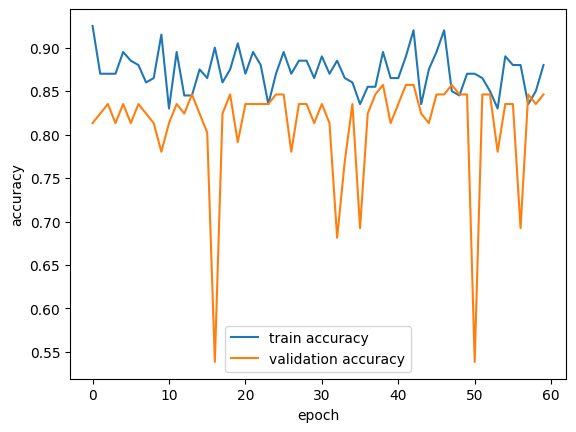

In [ ]:
show_plots(epochs, accuracy_dic, 'accuracy')

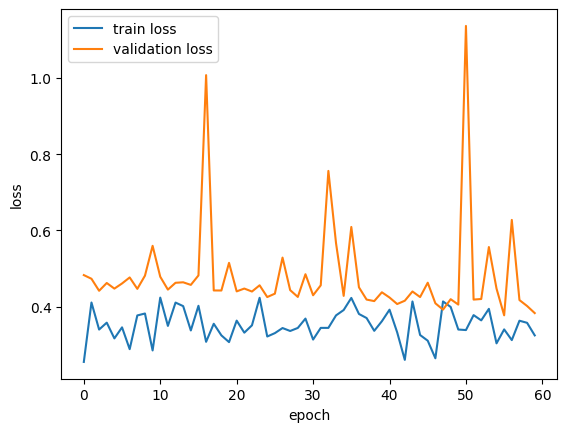

In [ ]:
show_plots(epochs, loss_dic, 'loss')

## Evaluation

In [ ]:
# Implement the test method here (4 points)
def test(model, loader):
  model.eval()
  test_loss = 0.

  test_error = 0.
  correct_label_pred = 0

  for batch_idx, (data, label) in enumerate(loader):

      bag_label = label[0]
      data, bag_label = data.to(device), bag_label.to(device)
      data, bag_label = Variable(data), Variable(bag_label)
      data = data.squeeze(0)

      optimizer.zero_grad()

      # calculate loss and metrics
      with torch.set_grad_enabled(False):
        loss, _ = model.calculate_objective(data, bag_label)
        error, predicted_label_test = model.calculate_classification_error(data, bag_label)

      # statistics
      test_loss += loss.item()
      test_error += error
      correct_label_pred += (int(bag_label) == int(predicted_label_test))


  # calculate loss and error for epoch
  test_loss /= len(loader)
  test_error /= len(loader)
  test_acc = (1 - test_error)

  return test_loss, test_error, test_acc

In [ ]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
# Test the model trained on the 40X data here (1 points)
magn = "40X"
test(model, dataloaders[magn]['test'])

(0.3947888439035286, 0.13712374581939799, 0.862876254180602)

In [ ]:
# Test the model trained on the 100X data here (1 points)
magn = "100X"
test(model, dataloaders[magn]['test'])

(0.3872688157627216, 0.14423076923076922, 0.8557692307692308)

In [ ]:
# Test the model trained on the 200X data here (1 points)
magn = "200X"
test(model, dataloaders[magn]['test'])

(0.33861607071507316, 0.11295681063122924, 0.8870431893687708)

In [ ]:
# Test the model trained on the 400X data here (1 points)
magn = "400X"
test(model, dataloaders[magn]['test'])

(0.2933541284737624, 0.11721611721611722, 0.8827838827838828)

Resourses:
- [Github](https://github.com/Dipeshtamboli/Image-Classification-and-Localization-using-Multiple-Instance-Learning/tree/master)